In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011220139..1.2249732].


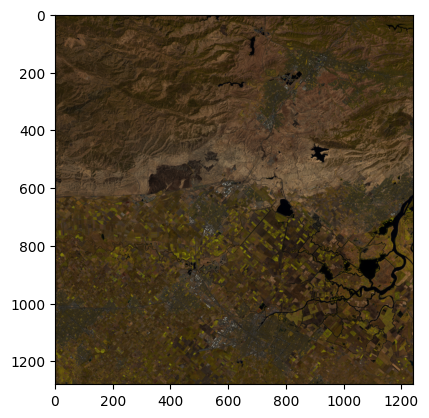

In [4]:
train_data = np.load("../data/numpy_EMIT_L2A_RFL_001_20240930T200354_2427413_001.npy")
df = 1700 / train_data.shape[2]
db = int(200 / df)
dg = int(300 / df)
dr = int(500 / df)
plt.imshow(train_data[:, :, [dr, dg, db]])
rgb_train_data = train_data[:, :, [dr, dg, db]]

In [5]:
# グレースケールに変換（一般的な係数を使用: R*0.2989 + G*0.5870 + B*0.1140）
gray_train_data = (
    0.2989 * rgb_train_data[:, :, 0] +
    0.5870 * rgb_train_data[:, :, 1] +
    0.1140 * rgb_train_data[:, :, 2]
)
gray_train_data = (gray_train_data / gray_train_data.max() * 255).astype(np.uint8)
#median_value = np.median(gray_train_data)
#gray_train_data[gray_train_data > median_value] = 255
#gray_train_data[gray_train_data <= median_value] = 0

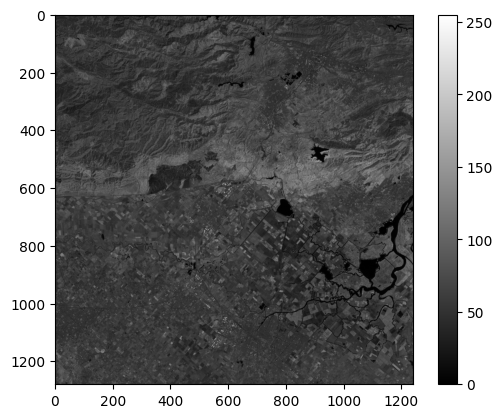

In [6]:
plt.imshow(gray_train_data,cmap='gray')
plt.colorbar()
plt.show()

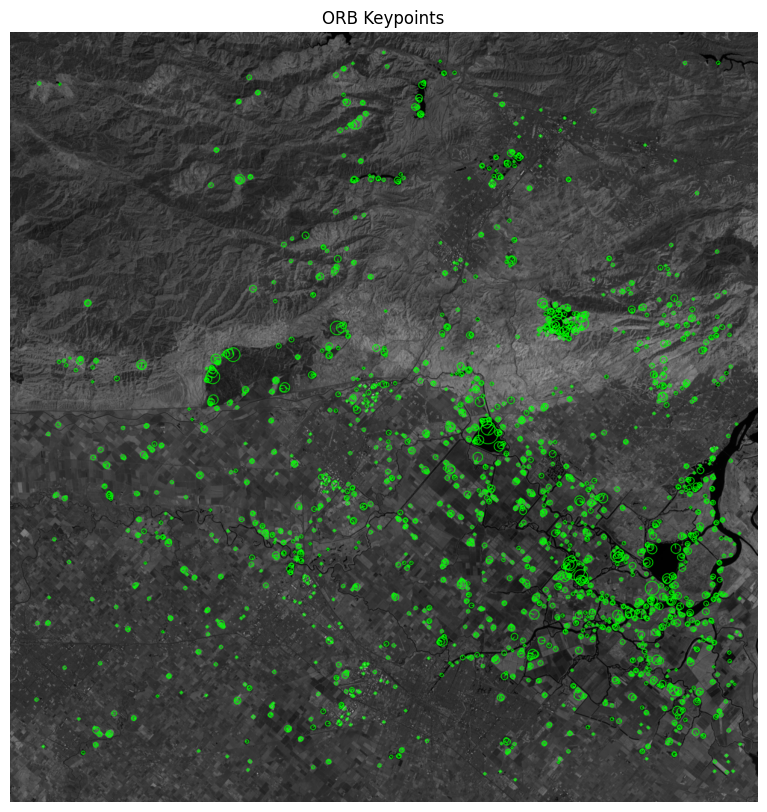

In [7]:
# ORBによるキーポイント検出
train_orb = cv2.AKAZE_create() # ORB_createだとうまくいかない
train_keypoints, train_descriptors = train_orb.detectAndCompute(gray_train_data, None)

# キーポイントを画像上に描画
train_keypoint_image = cv2.drawKeypoints(
    gray_train_data, train_keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS
)

# Matplotlibで表示
plt.figure(figsize=(10, 10))
plt.imshow(train_keypoint_image)
plt.title("ORB Keypoints")
plt.axis('off')
plt.show()

In [8]:
label_data = np.load("numpy_EMIT_L2B_CH4ENH_001_20240930T200354_2427413_001.npy")
#label_data[label_data > 0] = 1
#label_data[label_data <= 0] = 0
label_data = (label_data / label_data.max() * 255).astype(np.uint8)

FileNotFoundError: [Errno 2] No such file or directory: 'numpy_EMIT_L2B_CH4ENH_001_20240930T200354_2427413_001.npy'

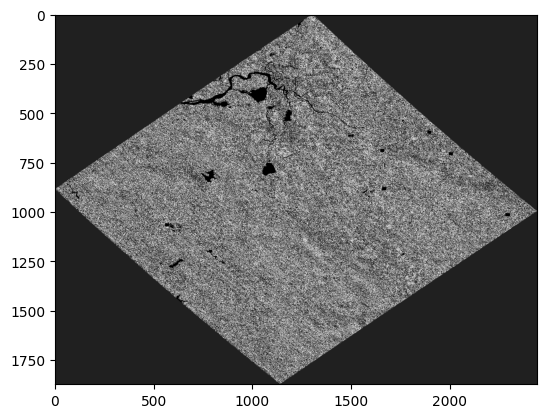

In [7]:
plt.imshow(label_data, cmap="gray")

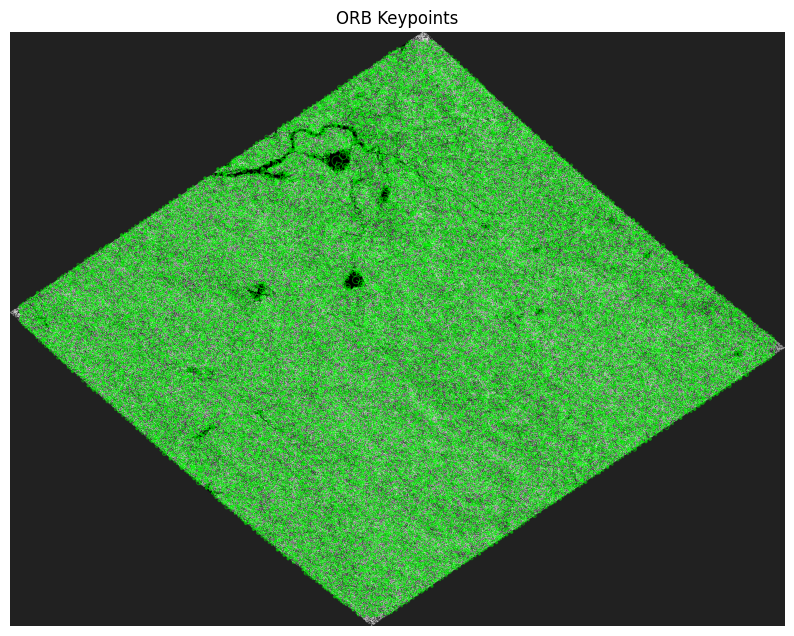

In [8]:
# ORBによるキーポイント検出
label_orb = cv2.AKAZE_create() # ORB_createだとうまくいかない
label_keypoints, label_descriptors = label_orb.detectAndCompute(label_data, None)

# キーポイントを画像上に描画
label_keypoint_image = cv2.drawKeypoints(
    label_data, label_keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS
)

# Matplotlibで表示
plt.figure(figsize=(10, 10))
plt.imshow(label_keypoint_image)
plt.title("ORB Keypoints")
plt.axis('off')
plt.show()

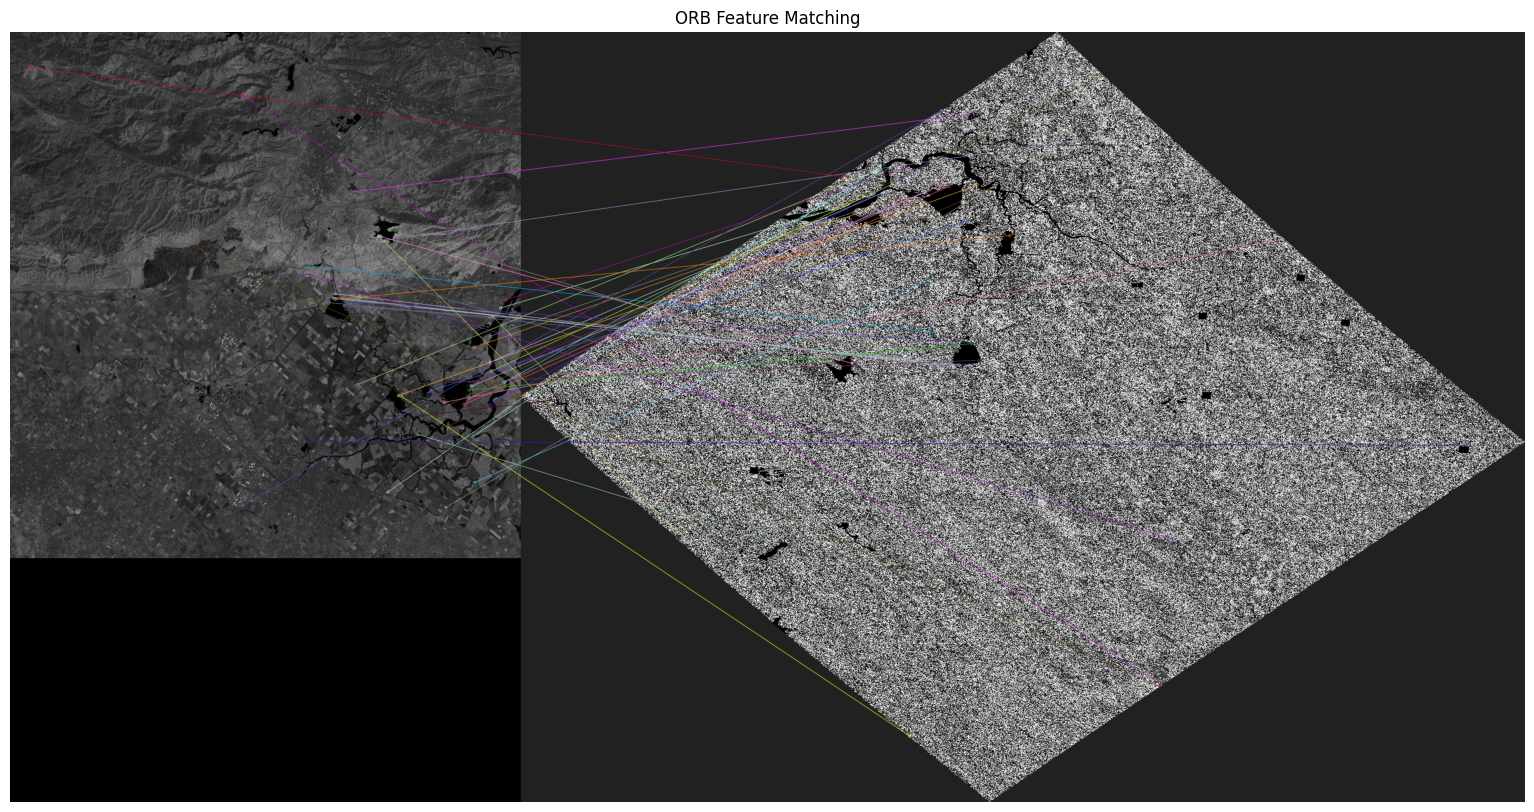

In [9]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(train_descriptors, label_descriptors)

# マッチングを距離でソート（近いものが良いマッチング）
matches = sorted(matches, key=lambda x: x.distance)

# 5. マッチング結果を描画
match_img = cv2.drawMatches(
    gray_train_data, train_keypoints, label_data, label_keypoints, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Matplotlibで表示
plt.figure(figsize=(20, 10))
plt.imshow(match_img)
plt.title("ORB Feature Matching")
plt.axis('off')
plt.show()

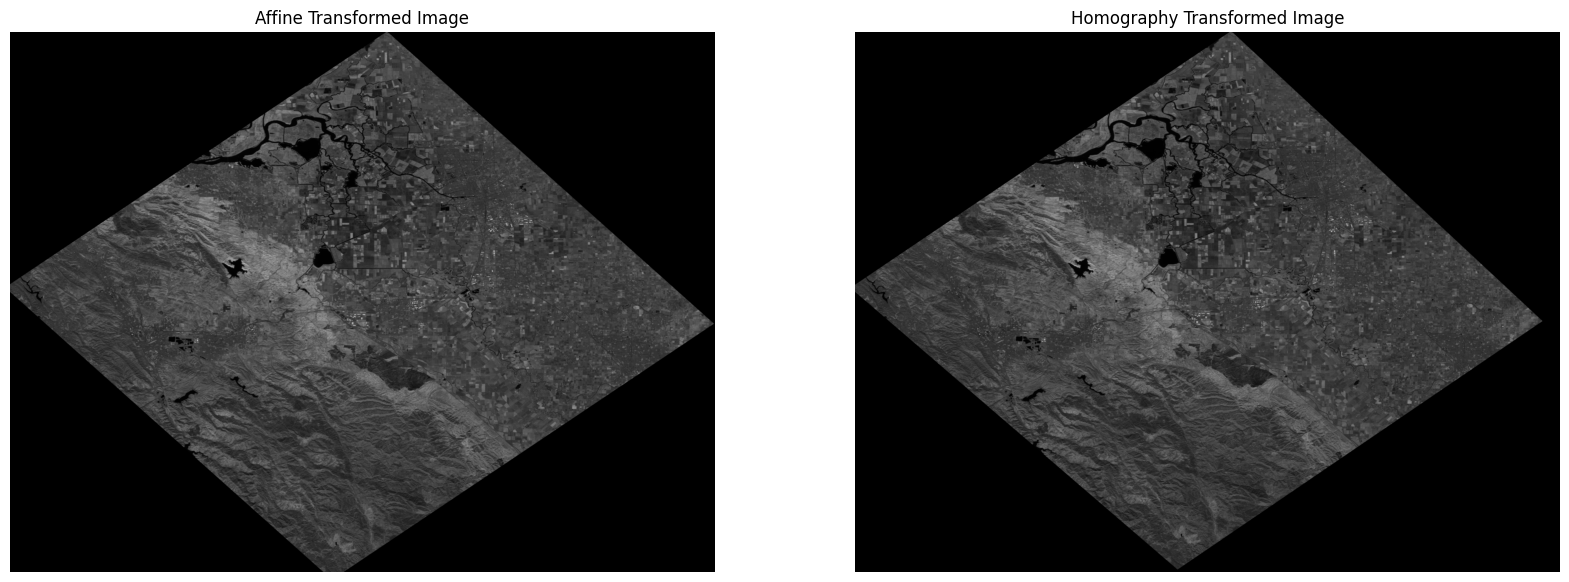

In [10]:
pts1 = np.array([train_keypoints[m.queryIdx].pt for m in matches[:50]], dtype=np.float32)
pts2 = np.array([label_keypoints[m.trainIdx].pt for m in matches[:50]], dtype=np.float32)

# 7. アフィン変換または射影変換を計算
# アフィン変換の場合
matrix_affine, inliers = cv2.estimateAffine2D(pts1, pts2)

# 射影変換（ホモグラフィー）の場合
matrix_homography, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

# 8. 変換を適用
# アフィン変換の場合
warped_image_affine = cv2.warpAffine(gray_train_data, matrix_affine, (label_data.shape[1], label_data.shape[0]))

# 射影変換の場合
warped_image_homography = cv2.warpPerspective(gray_train_data, matrix_homography, (label_data.shape[1], label_data.shape[0]))

# 9. 結果の表示
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(warped_image_affine, cmap='gray')
plt.title("Affine Transformed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(warped_image_homography, cmap='gray')
plt.title("Homography Transformed Image")
plt.axis('off')

plt.show()

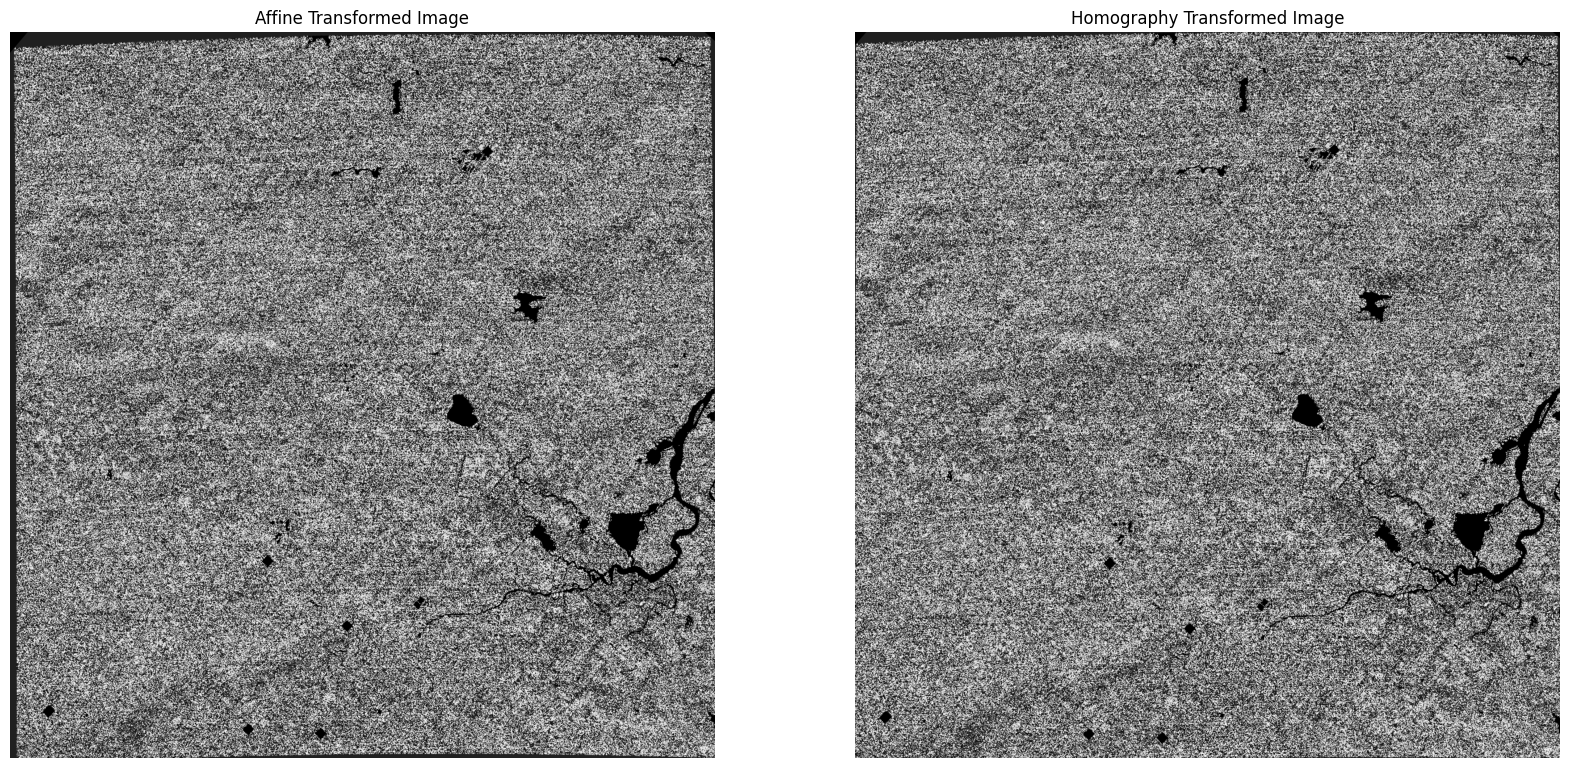

In [11]:
pts1 = np.array([train_keypoints[m.queryIdx].pt for m in matches[:50]], dtype=np.float32)
pts2 = np.array([label_keypoints[m.trainIdx].pt for m in matches[:50]], dtype=np.float32)

# 7. アフィン変換または射影変換を計算
# アフィン変換の場合
matrix_affine, inliers = cv2.estimateAffine2D(pts2, pts1)

# 射影変換（ホモグラフィー）の場合
matrix_homography, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)

# 8. 変換を適用
# アフィン変換の場合
warped_image_affine = cv2.warpAffine(label_data, matrix_affine, (gray_train_data.shape[1], gray_train_data.shape[0]))

# 射影変換の場合
warped_image_homography = cv2.warpPerspective(label_data, matrix_homography, (gray_train_data.shape[1], gray_train_data.shape[0]))

# 9. 結果の表示
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(warped_image_affine, cmap='gray')
plt.title("Affine Transformed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(warped_image_homography, cmap='gray')
plt.title("Homography Transformed Image")
plt.axis('off')

plt.show()